In [1]:
import segmentation_models as sm
import numpy as np
import sys, os
from tensorflow.keras.utils import normalize
from matplotlib.pyplot import plot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

Segmentation Models: using `keras` framework.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=8192)]
    )

logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
tf.config.get_logical_device_configuration(gpus[0])

1 Physical GPU, 1 Logical GPUs


[LogicalDeviceConfiguration(memory_limit=8192, experimental_priority=None, experimental_device_ordinal=0)]

In [3]:
sys.path.insert(1, 'E:/Research/course research projects/data-driven software engineering/gui-element-detection/src')
from constants import VINS_MERGED_YOLO_SPLITS_IMAGES as imgs_path
from constants import VINS_MERGED_YOLO_SPLITS_LABELS as labels_path
from util.data_utils import LazyDataLoaderV2, Splits
# from ..util.data_utils import LazyDataLoader, Splits
# from ..constants import VINS_MERGED_YOLO_SPLITS_IMAGES as imgs_path
# from ..constants import VINS_MERGED_YOLO_SPLITS_LABELS as labels_path

In [4]:
batch_size = 16
classes = 12 + 1

In [5]:
def get_data_loader(split):
    return LazyDataLoaderV2(split=split, images_path=imgs_path, labels_path=labels_path, batch_size=batch_size,
                          n_classes=classes, resize=True, shape=(416, 416), normalize=True)

In [6]:
train_loader = get_data_loader(Splits.TRAIN)
validation_loader = get_data_loader(Splits.VALIDATION)
test_loader = get_data_loader(Splits.TEST)

In [7]:


activation = 'softmax'
learning_rate = 0.0001
opt = Adam(learning_rate)
# dice_loss = sm.losses.DiceLoss()  # makes sense as the end result is highly imbalanced
# class_weights=tf.convert_to_tensor(np.array([0.25, 0.25, 0.25, 0.25]))
# focal_loss = sm.losses.CategoricalFocalLoss()  # why not Categorical CE ?
# total_loss = dice_loss + (focal_loss * 1)
total_loss = sm.losses.CategoricalCELoss()
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.IOUScore(threshold=0.9,name='iou score @ 0.9'), sm.metrics.FScore(threshold=0.5),
           sm.metrics.Precision(), sm.metrics.Recall()]  # this is all they have :|

In [8]:
RESNET_BACKBONE = 'resnet34'
preprocess_inputs = sm.get_preprocessing(RESNET_BACKBONE)

train_loader = preprocess_inputs(train_loader)
test_loader = preprocess_inputs(test_loader)
validation_loader = preprocess_inputs(validation_loader)

In [9]:
callbacks = [
    ModelCheckpoint('./best_model_v2_1_{epoch}.h5', save_weights_only=True, save_best_only=True, mode='min'),
    ReduceLROnPlateau(),
]

In [10]:
model1 = sm.Unet(RESNET_BACKBONE, encoder_weights='imagenet', classes=13, activation=activation)
model1.compile(opt, total_loss, metrics=metrics)

In [11]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [15]:
# history = model1.fit_generator(
#     train_loader,
#     steps_per_epoch=len(train_loader),
#     epochs=100,
#     callbacks=callbacks,
#     validation_data=validation_loader,
#     validation_steps=len(validation_loader),
# )
history = model1.fit(
    train_loader,
    steps_per_epoch=len(train_loader),
    epochs=100,
    callbacks=callbacks,
    validation_data=validation_loader,
    validation_steps=len(validation_loader),
)

Epoch 1/100
227/227 [==============================] - 192s 774ms/step - loss: 0.1298 - iou_score: 0.2535 - iou score @ 0.9: 0.2156 - f1-score: 0.2804 - precision: 0.1403 - recall: 0.3507 - val_loss: 0.1317 - val_iou_score: 0.2330 - val_iou score @ 0.9: 0.1923 - val_f1-score: 0.2452 - val_precision: 0.0833 - val_recall: 0.2695 - lr: 1.0000e-04
Epoch 2/100
227/227 [==============================] - 170s 748ms/step - loss: 0.0661 - iou_score: 0.3658 - iou score @ 0.9: 0.1612 - f1-score: 0.4155 - precision: 0.2467 - recall: 0.4166 - val_loss: 0.1269 - val_iou_score: 0.1889 - val_iou score @ 0.9: 0.1511 - val_f1-score: 0.2075 - val_precision: 0.1269 - val_recall: 0.2577 - lr: 1.0000e-04
Epoch 3/100
227/227 [==============================] - 172s 757ms/step - loss: 0.0440 - iou_score: 0.4717 - iou score @ 0.9: 0.2163 - f1-score: 0.5256 - precision: 0.3447 - recall: 0.5151 - val_loss: 0.1192 - val_iou_score: 0.2663 - val_iou score @ 0.9: 0.1498 - val_f1-score: 0.3247 - val_precision: 0.2377 

NameError: name 'history' is not defined

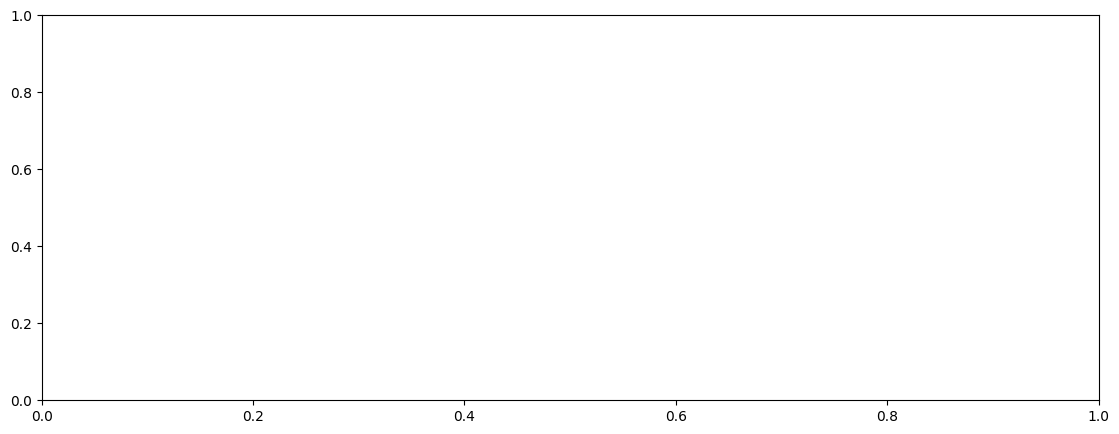

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
model1.load_weights('best_model_v2_1_32.h5')


In [12]:
scores = model1.evaluate_generator(test_loader)
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

C:\Users\Shayan\AppData\Local\Temp\ipykernel_27288\1918482598.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model1.evaluate_generator(test_loader)


Loss: 0.028665
mean iou_score: 0.67189
mean iou score @ 0.9: 0.67102
mean f1-score: 0.72633
mean precision: 0.60706
mean recall: 0.80065


In [14]:
a,b = test_loader[10]

In [22]:
from util.data_utils import merge_bounding_boxes
bgt = merge_bounding_boxes(b)
import cv2
cv2.imshow("sds",bgt[0])
cv2.waitKey()

-1

In [16]:
p = model1.predict([a])

1/1 [==============================] - 5s 5s/step


In [21]:
pt = p[0]
pt[pt < 0.5] = 0
pt[pt >= 0.5] = 1
pt = merge_bounding_boxes(pt)
cv2.imshow("p",pt)
cv2.waitKey()

-1

In [1]:
print("sds")

sds


In [13]:
m = load_model('res34bb_UNET_100epochs.hdf5',compile=False)

In [16]:
m

TypeError: 'NoneType' object is not subscriptable